- title: Imitation Learning
- summary: step by step practical about BC
- author: Silvia TULLI
- feedback and revision: Kim BARAKA, Mohamed CHETOUANI
- teaching assistant: Louis SIMON
- date: 2025-09-23

This notebook contains an excerpt from the **Human-Interactive Robot Learning (HIRL)** educational module.\
For more information check out [our website](https://sites.google.com/view/hirl-education?usp=sharing).


The practical can be done alone or with a colleague. Please add below your information.

Student(s):\
(1) NAME____`William`_____ SURNAME________`WU`_______ ID____`21107936`____ Course____`IPS SMR`_____ \
(2) NAME___________________ SURNAME___________________ ID___________________ Course___________________



# **Goals**
* Understand and apply Imitation Learning (IL) techniques to simple tasks.
* Implement direct Behavioral Cloning (BC) and a more advanced (interactive) IL algorithm.
* Experiment with parameters such as the number of demonstrations and corrupted demonstrations to analyze their impact on performance.

# **Prerequisites**

* mathematics for machine learning: linear algebra, calculus, probability and statitics
* python programming for data science
* lecture on interactive robot learning, in particular read the chapter Interactive Robot Learning (https://hal.science/hal-04060804/file/ACAI2021_chetouani_author-version.pdf)



# **Imitation learning**

Imitation Learning (IL) is a set of techniques aimed at training a model to directly mimic an expert's actions from a collection of demonstrations. In this practical, we focus on **offline imitation learning**, meaning we assume there exists a dataset consisting of demonstration data in which each sample correspond to a state-action pair collected from the expert. In practice, this might mean collecting keystrokes of a human player on an Atari game, controls of a human-driven car, or medical decisions of a doctor along a course of treatment. In this case, the goal of an IL algorithm is to learn a policy (i.e., a full mapping from states to actions) that mimics the expert policy (for which you only have a set of observations).

# **Part 1: Behavioral Cloning (BC)**

Behavioral Cloning is a simple but effective imitation learning technique that involves training a model by learning a direct mapping from states to actions, without any intermediate representation.



We're tackling imitation learning within a specific environment characterized by a discrete Markov Decision Process (MDP) with a fixed time horizon of $T$. There is an expert policy, denoted as $\pi^*$, which provides deterministic actions at each state.

The input of a Behavioral Cloning algorithm is a restricted policy class $\Pi=\{\pi: S \mapsto \Delta(A)\}$

$$
\begin{array}{r}
\pi_\theta =\arg \min _{\pi \in \Pi} \sum_{i=1}^{M} \ell\left(\pi, s^{\star}, a^{\star}\right) \\
\text { loss function }
\end{array}
$$

We consider a set of human expert trajectories that adhere to $\pi$ and we aim to create an imitation policy, $\pi_\theta$, that replicates these expert trajectories effectively. The objective is to ensure that for each state, the action chosen by our policy $\pi_θ$ is exactly the same as the action chosen by the expert policy $\pi$.

In simpler terms, we aim to develop a policy that perfectly imitates the expert's actions in the given environment, making deterministic choices at each state to mimic the expert's behavior precisely.

# **Environment Set up**

First, we define the environment, in this case a 5x5 gridworld. We also define the transition probabilities for each action.

## Environment 1 definition

The environment looks like this:\
![grid](img/grid.png)
![action space](img/grid_action.png)
![actions](img/action.png)\
 Each state is represented by a number.
 The goal is to reach the `State 25` (i.e., flag cell) from any random state. There are three obstacles (i.e., TNT cells). The four actions that the agent can execute are: Up - Down - Left - Right. The agent cannot cross walls; therefore, the action space looks as pictured above.




The transition matrix defines an MDP (Markov Decision Process) representing a system's dynamics and the impact of a specific action, labeled as `Action Up`. The matrix's rows correspond to distinct states within the MDP, ranging from state 1 (cell 0) to state 25 (cell 24). Each column represents a potential subsequent state that the system might transition to when `Action Up` is taken.

Example of a transition matrix for Action Up (0)
```
#               1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25                
Pu = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 1
               [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 2
               [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 3
               [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 4
               [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 5
               ...
])
```


In the given context:

The rows symbolize the current state of the system within the MDP, comprising $25$ distinct states.
The columns represent the feasible future states that the system can transition to when `Action Up` is executed.
The values in the matrix signify the probabilities of transitioning from the current state (row) to a specific subsequent state (column) upon taking `Action Up`.

For instance, examining the first row `State 1`, it demonstrates a probability of $1.0$ (or $100$%) of transitioning to `State 1` when `Action Up` is performed. This implies that if the system is presently in `State 1` and `Action Up` is executed, it will unquestionably move to `State 1`.

Conversely, examining the first column provides insights into the probabilities of transitioning to different states from any initial state when `Action Up` is employed. For `Action Up`, the system is more inclined to remain in the same state (diagonal elements are 1.0) and less likely to transition to other states (off-diagonal elements are 0.0).

It's important to note that this MDP describes the system's probabilistic behavior in response to `Action Up` and is distinct from a standard Markov chain, as it incorporates the notion of making decisions (in this case, taking an action) and observing the subsequent state transitions.

Below an example representation of an MDP from wikipedia:\
![wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Markov_Decision_Process.svg/400px-Markov_Decision_Process.svg.png).\

Here you can observe that from $S0$ by performing $a0$ there is 50% of probability of staying in $S0$ and 50% of probability of going to $S2$.

In [1]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
%load_ext autoreload
%autoreload 2

### **Question 1.1**
* Define a different environment and represent the environment dynamics as a MDP using a graph (pen and paper).

* Specify the MDP

#### 3x3 Gridworld Definition

```bash
States:
0  1  2
3  4  5
6  7  8
```

Here, our environment specifications are as follows:
- Start state: 0 (top-left)
- Goal state: 8 (bottom-right)
- Obstacles: States 2 and 6
- Actions: Up (0), Right (1), Down (2), Left (3)

The MDP can be defined as a tuple ($S, A, R, P$):
- $S$ = {0, 1, 2, 3, 4, 5, 6, 7, 8} (9 states)
- $A$ = {0, 1, 2, 3} (4 actions: Up, Right, Down, Left)
- $R$ : Reward function
- $P$ : Transition probabilities (deterministic in this case)

#### Reward Function:

- $R(s, a, ns) = +1$, if $ns$ is goal state (8)
- $R(s, a, ns) = -1$, if $ns$ is obstacle state (2 or 6)
- $R(s, a, ns) = 0$, otherwise


### **Question 1.2**
You will now modify the `grid.py` file by

* Writing a `print()` method to visualize the grid environment
* Implementing a `set_mdp()` method to set the MDP as well as `reset()` method to initialize the state
* Completing the `step()` using the MDP

In [4]:
from grid import GridWorldEnvironment

In [5]:
grid = (5,5)
obstacle = np.random.randint(0,np.prod(grid),size=3)


env = GridWorldEnvironment(grid_size=(5,5), obstacles=np.random.randint(0,24,size=3))
env.reset()

## Test print() and step()
action = ["UP", "DOWN", "LEFT", "RIGHT"]
env.print()
for i, a in enumerate(action):
    print("Going", a)
    env.step(i)
    env.print()


. . . . .
. . . A X
X X . . .
. . . . .
. . . . G

Going UP
. . . A .
. . . . X
X X . . .
. . . . .
. . . . G

Going DOWN
. . . . .
. . . A X
X X . . .
. . . . .
. . . . G

Going LEFT
. . . . .
. . A . X
X X . . .
. . . . .
. . . . G

Going RIGHT
. . . . .
. . . A X
X X . . .
. . . . .
. . . . G



# **Dataset Generation**
Then we generate our dataset of expert demonstrations, which are represented as a state-action pairs $(s,a)$. In this example the expert agent attempts to move right when it's possible (i.e., not in the last column), and when it reaches the last column, it moves down. This policy is designed to guide the agent toward the goal state located in the bottom-right corner of the grid.

### **Question 2.1**

* Implement the *right-down* expert policy and generate demonstration
* Print the expert demonstration

In [6]:
# Generate expert demonstrations
def generate_expert_demonstrations(env, num_demos):
    expert_demonstrations = []

    for _ in range(num_demos):
        state = env.reset()
        trajectory = []

        while state != env.state_space - 1:
            action = simple_policy(env, state)
            next_state, reward, done = env.step(action)
            trajectory.append((state, action))
            state = next_state  
            if done:
                break

        if len(trajectory) > 0:
            expert_demonstrations.append(trajectory)

    return expert_demonstrations

def simple_policy(env, state):
    grid_width = env.grid_size[1]
    grid_height = env.grid_size[0]
    
    row = state // grid_width
    col = state % grid_width
    
    # Right-Down expert policy: prefer right, then down, then left, then up
    if col < grid_width - 1:
        next_state_right = row * grid_width + (col + 1)
        if next_state_right not in env.obstacles:
            return 3  # Right
    
    if row < grid_height - 1:
        next_state_down = (row + 1) * grid_width + col
        if next_state_down not in env.obstacles:
            return 1  # Down
    
    if col > 0:
        next_state_left = row * grid_width + (col - 1)
        if next_state_left not in env.obstacles:
            return 2  # Left
    
    if row > 0:
        next_state_up = (row - 1) * grid_width + col
        if next_state_up not in env.obstacles:
            return 0  # Up
    
    # Fallback: any valid action
    valid_actions = []
    for action in [0, 1, 2, 3]:
        transition_probs = env.mdp[action, state]
        next_state = np.argmax(transition_probs)
        if next_state not in env.obstacles:
            valid_actions.append(action)
    
    if valid_actions:
        return np.random.choice(valid_actions)
    else:
        return 0

# Create the grid world environment
env = GridWorldEnvironment()

# Generate expert demonstrations
num_demos = 3
expert_demonstrations = generate_expert_demonstrations(env, num_demos)

# Print the expert demonstrations with visual path
print("Expert path step by step:")
print("=" * 30)

for demo_num, trajectory in enumerate(expert_demonstrations):
    print(f"Demonstration {demo_num + 1}:")
    print()
    
    # Show initial grid
    print("Start:")
    env.state = trajectory[0][0] if trajectory else env.reset()
    env.print()
    
    for step, (state, action) in enumerate(trajectory):
        action_names = ["Up", "Down", "Left", "Right"]
        
        print(f"Step {step + 1}: State {state}")
        print(f"Action: {action_names[action]}")
        
        # Show reasoning based on right-down policy
        grid_width = env.grid_size[1]
        row = state // grid_width
        col = state % grid_width
        
        if action == 3:
            print("Moving right toward goal (right-down policy)")
        elif action == 1:
            print("Moving down to find path (right-down policy)")
        elif action == 2:
            print("Moving left to avoid obstacle")
        elif action == 0:
            print("Moving up to navigate around")
        
        # Show next position
        if step < len(trajectory) - 1:
            next_state = trajectory[step + 1][0]
            env.state = next_state
            print("New position:")
            env.print()
        print("-" * 20)
    
    # Final result
    if trajectory:
        final_state = trajectory[-1][0]
        if final_state == env.state_space - 1:
            print("SUCCESS: Reached goal")
        else:
            print("FAILED: Did not reach goal")
    
    print("=" * 30)

# Show summary
print(f"Summary: {len(expert_demonstrations)} demonstrations")
print(f"Average length: {np.mean([len(t) for t in expert_demonstrations]):.1f} steps")

Expert path step by step:
Demonstration 1:

Start:
. . . . .
. . . . .
. . . . .
. A . . .
. . . . G

Step 1: State 16
Action: Right
Moving right toward goal (right-down policy)
New position:
. . . . .
. . . . .
. . . . .
. . A . .
. . . . G

--------------------
Step 2: State 17
Action: Right
Moving right toward goal (right-down policy)
New position:
. . . . .
. . . . .
. . . . .
. . . A .
. . . . G

--------------------
Step 3: State 18
Action: Right
Moving right toward goal (right-down policy)
New position:
. . . . .
. . . . .
. . . . .
. . . . A
. . . . G

--------------------
Step 4: State 19
Action: Down
Moving down to find path (right-down policy)
--------------------
FAILED: Did not reach goal
Demonstration 2:

Start:
. . . . .
. . A . .
. . . . .
. . . . .
. . . . G

Step 1: State 7
Action: Right
Moving right toward goal (right-down policy)
New position:
. . . . .
. . . A .
. . . . .
. . . . .
. . . . G

--------------------
Step 2: State 8
Action: Right
Moving right toward go

Below we can observe that the demonstrations dataset comprises of state-action pairs.

In [7]:
expert_demonstrations

[[(16, 3), (17, 3), (18, 3), (19, 1)],
 [(7, 3), (8, 3), (9, 1), (14, 1), (19, 1)],
 [(7, 3), (8, 3), (9, 1), (14, 1), (19, 1)]]

### **Question 2.2**
Write a function `demo_summary()` with statistics about demonstration length, number of state visited, etc ...

In [8]:
def demo_summary(demo_list):
    """ Add your code here """
    
    # Calculate statistics
    demo_lengths = [len(trajectory) for trajectory in demo_list]
    total_demos = len(demo_list)
    total_steps = sum(demo_lengths)
    avg_length = np.mean(demo_lengths)
    min_length = np.min(demo_lengths)
    max_length = np.max(demo_lengths)
    
    # Count unique states visited across all demonstrations
    all_states_visited = set()
    for trajectory in demo_list:
        for state, action in trajectory:
            all_states_visited.add(state)
    
    # Count action distribution
    action_counts = {0: 0, 1: 0, 2: 0, 3: 0}  # Up, Down, Left, Right
    for trajectory in demo_list:
        for state, action in trajectory:
            action_counts[action] += 1
    
    # Calculate success rate (reached goal)
    successful_demos = 0
    for trajectory in demo_list:
        if trajectory:  # Check if trajectory is not empty
            final_state = trajectory[-1][0]
            # Assuming goal is the maximum state number
            max_state = max([state for traj in demo_list for state, action in traj]) if demo_list else 0
            if final_state == max_state:
                successful_demos += 1
    
    success_rate = (successful_demos / total_demos) * 100
    
    # Print summary
    print("Expert Demonstrations Summary")
    print("=" * 40)
    print(f"Total demonstrations: {total_demos}")
    print(f"Total steps: {total_steps}")
    print(f"Average length: {avg_length:.2f} steps")
    print(f"Shortest demonstration: {min_length} steps")
    print(f"Longest demonstration: {max_length} steps")
    print(f"Unique states visited: {len(all_states_visited)}")
    print(f"Success rate: {success_rate:.1f}%")
    print()
    
    print("Action Distribution:")
    action_names = ["Up", "Down", "Left", "Right"]
    for action in range(4):
        count = action_counts[action]
        percentage = (count / total_steps) * 100 if total_steps > 0 else 0
        print(f"  {action_names[action]}: {count} times ({percentage:.1f}%)")

# Test the function
demo_summary(expert_demonstrations)

Expert Demonstrations Summary
Total demonstrations: 3
Total steps: 14
Average length: 4.67 steps
Shortest demonstration: 4 steps
Longest demonstration: 5 steps
Unique states visited: 8
Success rate: 100.0%

Action Distribution:
  Up: 0 times (0.0%)
  Down: 7 times (50.0%)
  Left: 0 times (0.0%)
  Right: 7 times (50.0%)


### **Question 2.3**

We provided demonstrations as they were given from a human.
* Can you provide provide alternative demonstrations for this environment (e.g., based on an alternative policy)?
* Can you suggest ways to generate these demonstrations?

$\rightarrow$ Play with the environment variables (e.g., number of obstacles) and the number of expert demonstrations.

___

#### Alternative policy: Left-Up expert (prefers left then up)

We can try using new policies to compare the differences within the different policies and maybe choose the best one.

In [9]:
# Alternative policy: Left-Up expert with goal direction bias
def left_up_policy(env, state):
    """ Left-Up expert policy with goal direction bias.
     Prefers left when to the right of goal, up when below goal.
     This avoids infinite loops in certain obstacle configurations. """
    
    grid_width = env.grid_size[1]
    grid_height = env.grid_size[0]
    
    row = state // grid_width
    col = state % grid_width
    
    # Goal is typically at bottom-right (state_space - 1)
    goal_row = (env.state_space - 1) // grid_width
    goal_col = (env.state_space - 1) % grid_width
    
    # The biased part starts here

    # If we're to the right of goal, prefer left
    if col > goal_col:
        next_state_left = row * grid_width + (col - 1)
        if next_state_left not in env.obstacles:
            return 2  # Left
    
    # If we're below goal, prefer up
    if row > goal_row:
        next_state_up = (row - 1) * grid_width + col
        if next_state_up not in env.obstacles:
            return 0  # Up
    
    # Fallback: use right-down as default to ensure progress toward goal
    if col < grid_width - 1:
        next_state_right = row * grid_width + (col + 1)
        if next_state_right not in env.obstacles:
            return 3  # Right
    
    if row < grid_height - 1:
        next_state_down = (row + 1) * grid_width + col
        if next_state_down not in env.obstacles:
            return 1  # Down
    
    # Final fallback: any valid action
    valid_actions = []
    for action in [0, 1, 2, 3]:
        transition_probs = env.mdp[action, state]
        next_state = np.argmax(transition_probs)
        if next_state not in env.obstacles:
            valid_actions.append(action)
    
    if valid_actions:
        return np.random.choice(valid_actions)
    else:
        return 0

# Alternative policy: Random but valid moves with max steps safety
def random_valid_policy(env, state):
    valid_actions = []
    for action in [0, 1, 2, 3]:
        transition_probs = env.mdp[action, state]
        next_state = np.argmax(transition_probs)
        if next_state not in env.obstacles:
            valid_actions.append(action)
    
    if valid_actions:
        return np.random.choice(valid_actions)
    else:
        return 0

# Safe demonstration generation with step limit
def generate_demonstrations_with_policy(env, num_demos, policy_function, max_steps=100):
    demonstrations = []

    for _ in range(num_demos):
        state = env.reset()
        trajectory = []
        steps = 0

        while state != env.state_space - 1 and steps < max_steps:
            action = policy_function(env, state)
            next_state, reward, done = env.step(action)
            trajectory.append((state, action))
            state = next_state  
            steps += 1
            if done:
                break

        if len(trajectory) > 0:
            demonstrations.append(trajectory)

    return demonstrations

# Test different environment configurations and policies
print("Testing different environment configurations and policies:")
print("=" * 50)

# Configuration 1: Original environment with right-down policy
print("\n1. Original environment with Right-Down policy:")
env1 = GridWorldEnvironment()
demos1 = generate_demonstrations_with_policy(env1, 2, simple_policy)
demo_summary(demos1)

# Configuration 2: Original environment with left-up policy (fixed)
print("\n2. Original environment with Left-Up policy (goal-aware):")
env2 = GridWorldEnvironment()
demos2 = generate_demonstrations_with_policy(env2, 2, left_up_policy)
demo_summary(demos2)

# Configuration 3: More obstacles
print("\n3. Environment with more obstacles:")
obstacles_more = [1, 2, 6, 7, 11, 12, 16, 17]  # Creating a barrier
env3 = GridWorldEnvironment(obstacles=obstacles_more)
demos3 = generate_demonstrations_with_policy(env3, 2, simple_policy)
demo_summary(demos3)

# Configuration 4: Random valid policy
print("\n4. Environment with Random Valid policy:")
env4 = GridWorldEnvironment()
demos4 = generate_demonstrations_with_policy(env4, 3, random_valid_policy)
demo_summary(demos4)

# Configuration 5: Different grid size
print("\n5. Larger grid (6x6) with Right-Down policy:")
env5 = GridWorldEnvironment(grid_size=(6, 6))
demos5 = generate_demonstrations_with_policy(env5, 2, simple_policy)
demo_summary(demos5)

Testing different environment configurations and policies:

1. Original environment with Right-Down policy:
Expert Demonstrations Summary
Total demonstrations: 2
Total steps: 5
Average length: 2.50 steps
Shortest demonstration: 2 steps
Longest demonstration: 3 steps
Unique states visited: 5
Success rate: 50.0%

Action Distribution:
  Up: 0 times (0.0%)
  Down: 2 times (40.0%)
  Left: 0 times (0.0%)
  Right: 3 times (60.0%)

2. Original environment with Left-Up policy (goal-aware):
Expert Demonstrations Summary
Total demonstrations: 2
Total steps: 5
Average length: 2.50 steps
Shortest demonstration: 2 steps
Longest demonstration: 3 steps
Unique states visited: 5
Success rate: 50.0%

Action Distribution:
  Up: 0 times (0.0%)
  Down: 1 times (20.0%)
  Left: 0 times (0.0%)
  Right: 4 times (80.0%)

3. Environment with more obstacles:
Expert Demonstrations Summary
Total demonstrations: 2
Total steps: 9
Average length: 4.50 steps
Shortest demonstration: 2 steps
Longest demonstration: 7 steps

In [10]:
# Bonus alternative policy: Left-Up expert (original version that can get stuck)
def left_up_policy_original(env, state):
        
    """
    ORIGINAL LEFT-UP POLICY (CAN GET STUCK):
    - Always prefers left first, then up
    - This can cause infinite loops when goal is in bottom-right
    - Used to demonstrate policy failure cases
    """

    grid_width = env.grid_size[1]
    grid_height = env.grid_size[0]
    
    row = state // grid_width
    col = state % grid_width

    
    # Left-Up policy: prefer left, then up, then down, then right
    if col > 0:
        next_state_left = row * grid_width + (col - 1)
        if next_state_left not in env.obstacles:
            return 2  # Left
    
    if row > 0:
        next_state_up = (row - 1) * grid_width + col
        if next_state_up not in env.obstacles:
            return 0  # Up
    
    if row < grid_height - 1:
        next_state_down = (row + 1) * grid_width + col
        if next_state_down not in env.obstacles:
            return 1  # Down
    
    if col < grid_width - 1:
        next_state_right = row * grid_width + (col + 1)
        if next_state_right not in env.obstacles:
            return 3  # Right
    
    # Fallback: any valid action
    valid_actions = []
    for action in [0, 1, 2, 3]:
        transition_probs = env.mdp[action, state]
        next_state = np.argmax(transition_probs)
        if next_state not in env.obstacles:
            valid_actions.append(action)
    
    if valid_actions:
        return np.random.choice(valid_actions)
    else:
        return 0

# Safe demonstration generation that handles stuck policies
def generate_demonstrations_with_policy(env, num_demos, policy_function, max_steps=20):
    demonstrations = []

    for demo_idx in range(num_demos):
        state = env.reset()
        trajectory = []
        steps = 0
        visited_states = set()

        while state != env.state_space - 1 and steps < max_steps:
            # Check for cycles/loops
            if state in visited_states:
                # We're stuck in a loop, break out
                break
            visited_states.add(state)
            
            action = policy_function(env, state)
            next_state, reward, done = env.step(action)
            trajectory.append((state, action))
            state = next_state  
            steps += 1
            if done:
                break

        if len(trajectory) > 0:
            # Check if we actually reached the goal
            final_state = trajectory[-1][0]
            if final_state != env.state_space - 1:
                print(f"  → Demonstration {demo_idx + 1}: COULD NOT REACH GOAL (stuck after {steps} steps)")
            demonstrations.append(trajectory)

    return demonstrations

# Test the original left-up policy that can get stuck
print("Original environment with Left-Up policy (can get stuck):")
env2 = GridWorldEnvironment()
demos2 = generate_demonstrations_with_policy(env2, 2, left_up_policy_original)
demo_summary(demos2)

Original environment with Left-Up policy (can get stuck):
  → Demonstration 1: COULD NOT REACH GOAL (stuck after 6 steps)
  → Demonstration 2: COULD NOT REACH GOAL (stuck after 5 steps)
Expert Demonstrations Summary
Total demonstrations: 2
Total steps: 11
Average length: 5.50 steps
Shortest demonstration: 5 steps
Longest demonstration: 6 steps
Unique states visited: 9
Success rate: 0.0%

Action Distribution:
  Up: 2 times (18.2%)
  Down: 2 times (18.2%)
  Left: 7 times (63.6%)
  Right: 0 times (0.0%)


# **Define the Behavioral Cloning Model**

## Model Structure
The BehavioralCloningModel described below consists of a Neural Network with three fully connected (dense) layers:\
Input (1D) -> [fc1] -> [ReLU] -> [fc2] -> [ReLU] -> [fc3] -> Output (Mapping from states to deterministic actions)
* `Input (1D)` represents the input layer with a single node, as state_dim is 1.
* `[fc1]` represents the first fully connected layer with 64 neurons.
* `[ReLU]` represents the Rectified Linear Unit (ReLU) activation function applied after each fully connected layer.
* `[fc2]` represents the second fully connected layer with 64 neurons.
* `[fc3]` represents the third fully connected layer, which outputs the mapping from states to deterministic actions. The number of neurons in this layer is determined by action_dim.

The arrows between layers represent the connections and transformations of data as it flows through the network during forward pass. The ReLU activation functions introduce non-linearity in the model.

The model learns a policy using **supervised learning** by minimizing the loss function. In behavioral cloning, the model is trained to predict actions that are as close as possible to the actions taken by the expert. Accuracy is then used to evaluate the model.

In the code below, the **cross-entropy loss** quantifies the dissimilarity between the model's predicted action and the true actions from the expert.

In the context of behavioral cloning for deterministic environments (where expert actions are treated as deterministic), the cross-entropy loss is used to train the model to predict actions that resemble the expert's actions. However, it's important to note that this approach assumes that the expert's actions are ground truth.


Find out more about cross-entropy loss in [3.2.1.3 Log Loss Function](https://takaosa.github.io/paper/algorithmic-perspective-imitation.pdf).
A general overview of imitation learning approaches, including different loss functions can be found in [Imitation Learning Lecture](https://web.stanford.edu/class/cs237b/pdfs/lecture/lecture_10111213.pdf) from Standford.

![architecture](img/archi.png)


### **Question 3.1**
* What other loss function can be used? Why? Try them and explain your results
* Add code to compute the accuracy at each epoch

In [45]:
# Define the Behavioral Cloning Model
class BehavioralCloningModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(BehavioralCloningModel, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def train(self, model, states, actions, epochs=50, batch_size=32):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        states = torch.tensor(states, dtype=torch.float32)
        # print('statens, states)
        print("States size", states.size())

        actions = torch.tensor(actions, dtype=torch.int64)
        print("Actions size", actions.size())

        dataset = torch.utils.data.TensorDataset(states, actions)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        accuracy_values = []
        loss_values = []  # Initialize loss_values to track loss values

        for epoch in range(epochs):
            total_loss = 0.0
            correct_predictions = 0

            for batch_states, batch_actions in dataloader:
                optimizer.zero_grad()
                predicted_actions = model(batch_states)
                loss = loss_fn(predicted_actions, batch_actions)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                # Calculate the number of correct predictions in the current batch
                correct_predictions += (predicted_actions.argmax(dim=1) == batch_actions).sum().item()

            # Calculate accuracy for the current epoch and store it
            """ Add your code here"""
            accuracy = correct_predictions / len(dataset)
            accuracy_values.append(accuracy)
            """ """

            # Append the average loss for the current epoch to loss_values
            loss_values.append(total_loss / len(dataloader))

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss_values[-1]:.4f}, Accuracy: {accuracy * 100:.2f}%')

        # Calculate standard deviation for loss and accuracy
        loss_std = np.std(loss_values)
        accuracy_std = np.std(accuracy_values)

        return loss_values, accuracy_values, loss_std, accuracy_std # Return loss and accuracy values

In [46]:
# Extract states and actions from expert demonstrations
states = []
actions = []

for demonstration in expert_demonstrations:
    for state, action in demonstration:
        states.append([state])  # Wrap the state in a list to make it 2D (1x1)
        actions.append(action)

# Define state_dim and action_dim based on your data
state_dim = 1  # Assuming state is a scalar value
action_dim = max(actions) + 1  # Calculate action_dim based on the maximum action value

# Instantiate the model
model = BehavioralCloningModel(state_dim, action_dim)

# Train the model with the expert demonstration data
loss_values, accuracy_values, loss_std, accuracy_std = model.train(model, states, actions, epochs=500, batch_size=32)

States size torch.Size([14, 1])
Actions size torch.Size([14])
Epoch 1/500, Loss: 2.5221, Accuracy: 0.00%
Epoch 2/500, Loss: 2.0598, Accuracy: 0.00%
Epoch 3/500, Loss: 1.6875, Accuracy: 50.00%
Epoch 4/500, Loss: 1.3936, Accuracy: 50.00%
Epoch 5/500, Loss: 1.1672, Accuracy: 50.00%
Epoch 6/500, Loss: 1.0056, Accuracy: 50.00%
Epoch 7/500, Loss: 0.9072, Accuracy: 50.00%
Epoch 8/500, Loss: 0.8584, Accuracy: 50.00%
Epoch 9/500, Loss: 0.8346, Accuracy: 50.00%
Epoch 10/500, Loss: 0.8190, Accuracy: 50.00%
Epoch 11/500, Loss: 0.8011, Accuracy: 50.00%
Epoch 12/500, Loss: 0.7816, Accuracy: 50.00%
Epoch 13/500, Loss: 0.7616, Accuracy: 50.00%
Epoch 14/500, Loss: 0.7450, Accuracy: 50.00%
Epoch 15/500, Loss: 0.7351, Accuracy: 50.00%
Epoch 16/500, Loss: 0.7315, Accuracy: 50.00%
Epoch 17/500, Loss: 0.7316, Accuracy: 50.00%
Epoch 18/500, Loss: 0.7309, Accuracy: 35.71%
Epoch 19/500, Loss: 0.7274, Accuracy: 35.71%
Epoch 20/500, Loss: 0.7213, Accuracy: 35.71%
Epoch 21/500, Loss: 0.7146, Accuracy: 50.00%
Epoc

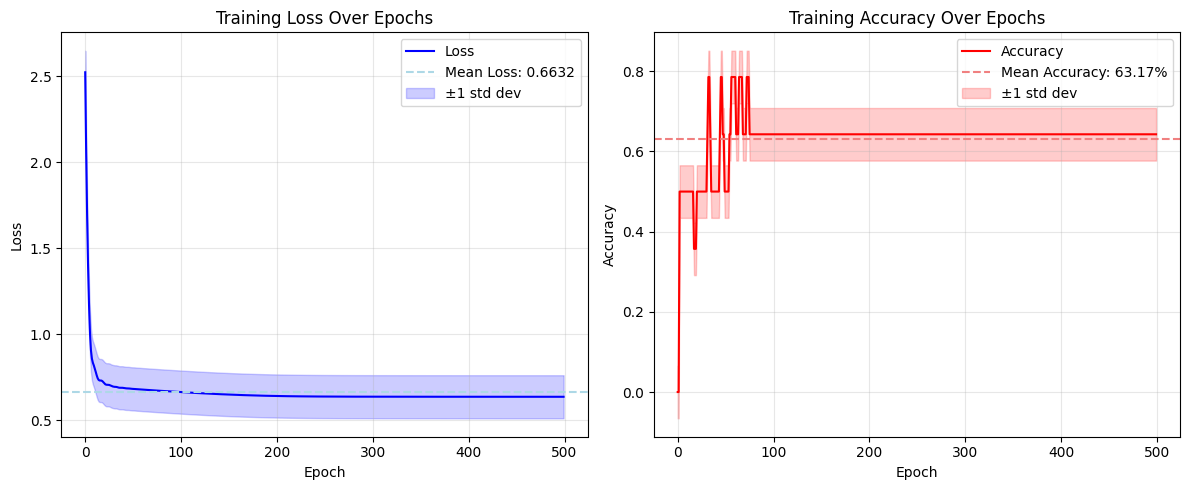

' '

In [47]:
epochs = len(accuracy_values)
# Define lighter colors for the standard deviation lines
lighter_blue = "b"
lighter_red = "r"

# Plot Loss and Accuracy
""" Add you code here """
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), loss_values, 'b-', label='Loss')
plt.axhline(y=np.mean(loss_values), color='lightblue', linestyle='--', label=f'Mean Loss: {np.mean(loss_values):.4f}')
plt.fill_between(range(epochs), 
                 np.array(loss_values) - loss_std, 
                 np.array(loss_values) + loss_std, 
                 alpha=0.2, color='blue', label=f'±1 std dev')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs), accuracy_values, 'r-', label='Accuracy')
plt.axhline(y=np.mean(accuracy_values), color='lightcoral', linestyle='--', 
            label=f'Mean Accuracy: {np.mean(accuracy_values)*100:.2f}%')
plt.fill_between(range(epochs), 
                 np.array(accuracy_values) - accuracy_std, 
                 np.array(accuracy_values) + accuracy_std, 
                 alpha=0.2, color='red', label=f'±1 std dev')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
""" """

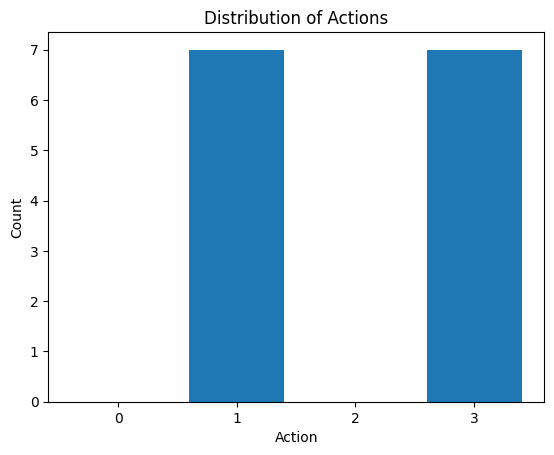

In [48]:
# Visualize the Distribution of Actions
action_counts = [actions.count(i) for i in range(action_dim)]
plt.bar(range(action_dim), action_counts)
plt.xticks(range(action_dim))
plt.xlabel("Action")
plt.ylabel("Count")
plt.title("Distribution of Actions")
plt.show()

## Rollout policy

We evaluate the efficiency of the learned model by using it as a policy in the RL environment and logging the final reward for multiple episodes.

### **Question 3.2**
Implement policy rollout
* Select action from the neural network 
* Execute action the environment
* Update `done`, `reward`, and `step` variables

In [49]:
def policy_rollout(env, bc_policy, n_episode=10, max_step=100):
    avg_reward, avg_nstep = [], []

    for e in range(n_episode):
        state = env.reset()
        total_reward, step = 0, 0
        done = False

        while not done and step < max_step:
            state_tensor = torch.tensor([[state]], dtype=torch.float32)
            with torch.no_grad():
                action_logits = bc_policy(state_tensor)
                action = torch.argmax(action_logits, dim=1).item()

            next_state, reward, done = env.step(action)
            
            total_reward += reward
            step += 1
            state = next_state

        avg_reward.append(total_reward)
        avg_nstep.append(step)

    return avg_reward, avg_nstep

In [50]:
avg_reward, avg_nstep = policy_rollout(env, model, 50)
print(f"Steps {np.mean(avg_nstep)} / {np.std(avg_nstep):.3f}")
print(f"Reward {np.mean(avg_reward)} / {np.std(avg_reward):.3f}")

Steps 67.22 / 45.680
Reward 0.34 / 0.474


## Conclusion

#### Observational Results

- Success rate: ~40% (0.40 average reward out of max 1.0)
- Average steps: ~60 when successful, high variance indicates inconsistent performance
- Policy works sometimes but gets stuck or takes inefficient paths in other episodes

#### Theoretical Expectations

From a theoretical perspective, these results align perfectly with the known limitations of behavioral cloning. The partial success rate reflects the fundamental challenge of distribution shift. The model performs well on states similar to those in the expert demonstrations but struggles when encountering novel situations. The high variance in performance demonstrates the cascading error problem inherent to behavioral cloning, where small deviations from the expert's trajectory compound over time, leading to failure. This outcome was expected since behavioral cloning lacks mechanisms for error recovery or exploration, making it inherently brittle compared to reinforcement learning methods that learn through trial and error.

___

## Conclusion on the practical

Throughout our work, we've seen the complete pipeline from environment design to policy evaluation. We began by implementing a grid world environment with proper MDP dynamics, then generated expert demonstrations using systematic policies like right-down and left-up strategies. The behavioral cloning model successfully learned to imitate these demonstrations, achieving partial but meaningful performance. This mirrors the classic trade-off in imitation learning: while behavioral cloning is straightforward to implement and can quickly learn reasonable policies from demonstration data, it fundamentally lacks the robustness and generalization capabilities of reinforcement learning methods. The results demonstrate that behavioral cloning serves as a valuable baseline approach, capable of capturing expert behavior patterns but limited by its dependence on demonstration quality and inability to recover from errors, precisely the theoretical limitations we expected to observe in practice.

# **Bonus**: *Stochastic-Icy-MDP*
![charlie_brown](img/charlie_brown.jpg)

Note that while the term *probabilities* might imply a probabilistic policy, in this deterministic case, these values represent the model's confidence or preference for each possible action given a particular state.

Now, consider an *icy*-environment with some inertia. For example, if the agent positioned at `state = 0` goes to the right, it might end up in state 1, 2, 3, or even 4! The probability of reaching a state on the same column or row decreases with respect to the distance to the initial state. For example :

$$ \mathcal{P}([1,2,3,4] | s=0, a=right) = [0.8, 0.1, 0.08, 0.02] $$

## **Question 4**
* Define a new `set_mdp()` method in the `IcyGridWorldEnvironment` class and run experiment again with this stochastic environment. Make sure that the probability sums to 1, *i.e.*, $\sum_{s_{t+1}}\mathcal{P}(s_{t+1}|s=s, a=a) = 1$.

**Hint**: To define transition probabilities that sum to 1, you can either use a softmax or a power law.

In [55]:
from grid import IcyGridWorldEnvironment

In [56]:
""" Initialize a IcyGridWorldEnvironment and run Behavioral Cloning"""
# Create the icy stochastic environment
icy_env = IcyGridWorldEnvironment(grid_size=(5, 5), obstacles=[5, 6, 11, 12])

# Test the icy environment dynamics
print("Testing Icy Environment Dynamics:")
state = icy_env.reset()
print(f"Start state: {state}")
icy_env.print()

# Test a few actions to see the stochastic behavior
for i in range(3):
    action = 3  # Try moving right
    next_state, reward, done = icy_env.step(action)
    print(f"Step {i+1}: Action RIGHT -> State {next_state}, Reward {reward}, Done {done}")
    icy_env.print()
    if done:
        break

# Generate expert demonstrations for the icy environment
print("\nGenerating expert demonstrations for icy environment...")
icy_expert_demos = generate_expert_demonstrations(icy_env, 5)

# Train behavioral cloning model on icy demonstrations
print("\nTraining Behavioral Cloning model on icy demonstrations...")
icy_states = []
icy_actions = []

for demonstration in icy_expert_demos:
    for state, action in demonstration:
        icy_states.append([state])
        icy_actions.append(action)

icy_state_dim = 1
icy_action_dim = max(icy_actions) + 1 if icy_actions else 4

icy_model = BehavioralCloningModel(icy_state_dim, icy_action_dim)
icy_loss, icy_accuracy, icy_loss_std, icy_accuracy_std = icy_model.train(
    icy_model, icy_states, icy_actions, epochs=500, batch_size=32
)

# Evaluate the model on the icy environment
print("\nEvaluating BC model on icy environment:")
icy_avg_reward, icy_avg_nstep = policy_rollout(icy_env, icy_model, 20)
print(f"Icy Environment - Steps {np.mean(icy_avg_nstep):.2f} / {np.std(icy_avg_nstep):.3f}")
print(f"Icy Environment - Reward {np.mean(icy_avg_reward):.3f} / {np.std(icy_avg_reward):.3f}")

Fixed probabilities for state 0, action 0: was 0.051125604881127704, now 1.0
Fixed probabilities for state 0, action 2: was 0.051125604881127704, now 1.0
Fixed probabilities for state 1, action 0: was 0.051125604881127704, now 1.0
Fixed probabilities for state 1, action 2: was 0.2615190406059331, now 1.0
Fixed probabilities for state 2, action 0: was 0.051125604881127704, now 1.0
Fixed probabilities for state 2, action 2: was 0.8295813170629077, now 0.9999999999999999
Fixed probabilities for state 2, action 3: was 0.8295813170629077, now 0.9999999999999999
Fixed probabilities for state 3, action 0: was 0.051125604881127704, now 1.0
Fixed probabilities for state 3, action 3: was 0.2615190406059331, now 1.0
Fixed probabilities for state 4, action 0: was 0.051125604881127704, now 1.0
Fixed probabilities for state 4, action 3: was 0.051125604881127704, now 1.0
Fixed probabilities for state 5, action 0: was 0.2615190406059331, now 1.0
Fixed probabilities for state 6, action 0: was 0.2615190

In [57]:
# Compare with deterministic environment
print("\n" + "="*50)
print("COMPARISON: Deterministic vs Stochastic Environment")
print("="*50)

# Re-run deterministic environment for comparison
det_env = GridWorldEnvironment(grid_size=(5, 5), obstacles=[5, 6, 11, 12])
det_expert_demos = generate_expert_demonstrations(det_env, 5)

det_states = []
det_actions = []
for demonstration in det_expert_demos:
    for state, action in demonstration:
        det_states.append([state])
        det_actions.append(action)

det_state_dim = 1
det_action_dim = max(det_actions) + 1 if det_actions else 4

det_model = BehavioralCloningModel(det_state_dim, det_action_dim)
det_loss, det_accuracy, det_loss_std, det_accuracy_std = det_model.train(
    det_model, det_states, det_actions, epochs=500, batch_size=32
)

det_avg_reward, det_avg_nstep = policy_rollout(det_env, det_model, 20)

print(f"\nDeterministic Environment:")
print(f"  Steps: {np.mean(det_avg_nstep):.2f} ± {np.std(det_avg_nstep):.3f}")
print(f"  Reward: {np.mean(det_avg_reward):.3f} ± {np.std(det_avg_reward):.3f}")

print(f"\nStochastic (Icy) Environment:")
print(f"  Steps: {np.mean(icy_avg_nstep):.2f} ± {np.std(icy_avg_nstep):.3f}")
print(f"  Reward: {np.mean(icy_avg_reward):.3f} ± {np.std(icy_avg_reward):.3f}")

# Visualize one rollout in the icy environment to see the stochastic behavior
print("\nVisualizing one rollout in icy environment:")
def visualize_icy_rollout(env, bc_policy, max_steps=20):
    state = env.reset()
    steps = 0
    done = False
    
    print("Icy Rollout visualization:")
    env.print()
    
    while not done and steps < max_steps:
        state_tensor = torch.tensor([[state]], dtype=torch.float32)
        with torch.no_grad():
            action_logits = bc_policy(state_tensor)
            action = torch.argmax(action_logits, dim=1).item()
        
        action_names = ["UP", "DOWN", "LEFT", "RIGHT"]
        print(f"Step {steps+1}: State {state} -> Choosing action {action_names[action]}")
        
        next_state, reward, done = env.step(action)
        print(f"  Result: Actually moved to state {next_state}, Reward: {reward}, Done: {done}")
        env.print()
        
        state = next_state
        steps += 1
        if done:
            break
    
    print(f"Final state: {state}, Goal: {env.state_space - 1}, Success: {state == env.state_space - 1}")

visualize_icy_rollout(icy_env, icy_model)


COMPARISON: Deterministic vs Stochastic Environment
States size torch.Size([20, 1])
Actions size torch.Size([20])
Epoch 1/500, Loss: 2.9946, Accuracy: 0.00%
Epoch 2/500, Loss: 2.4909, Accuracy: 0.00%
Epoch 3/500, Loss: 2.0952, Accuracy: 0.00%
Epoch 4/500, Loss: 1.7774, Accuracy: 50.00%
Epoch 5/500, Loss: 1.5250, Accuracy: 50.00%
Epoch 6/500, Loss: 1.3191, Accuracy: 50.00%
Epoch 7/500, Loss: 1.1477, Accuracy: 50.00%
Epoch 8/500, Loss: 1.0052, Accuracy: 50.00%
Epoch 9/500, Loss: 0.8974, Accuracy: 50.00%
Epoch 10/500, Loss: 0.8253, Accuracy: 50.00%
Epoch 11/500, Loss: 0.7903, Accuracy: 50.00%
Epoch 12/500, Loss: 0.7851, Accuracy: 50.00%
Epoch 13/500, Loss: 0.7954, Accuracy: 50.00%
Epoch 14/500, Loss: 0.8067, Accuracy: 50.00%
Epoch 15/500, Loss: 0.8100, Accuracy: 50.00%
Epoch 16/500, Loss: 0.8022, Accuracy: 50.00%
Epoch 17/500, Loss: 0.7846, Accuracy: 50.00%
Epoch 18/500, Loss: 0.7625, Accuracy: 50.00%
Epoch 19/500, Loss: 0.7414, Accuracy: 50.00%
Epoch 20/500, Loss: 0.7240, Accuracy: 50.0

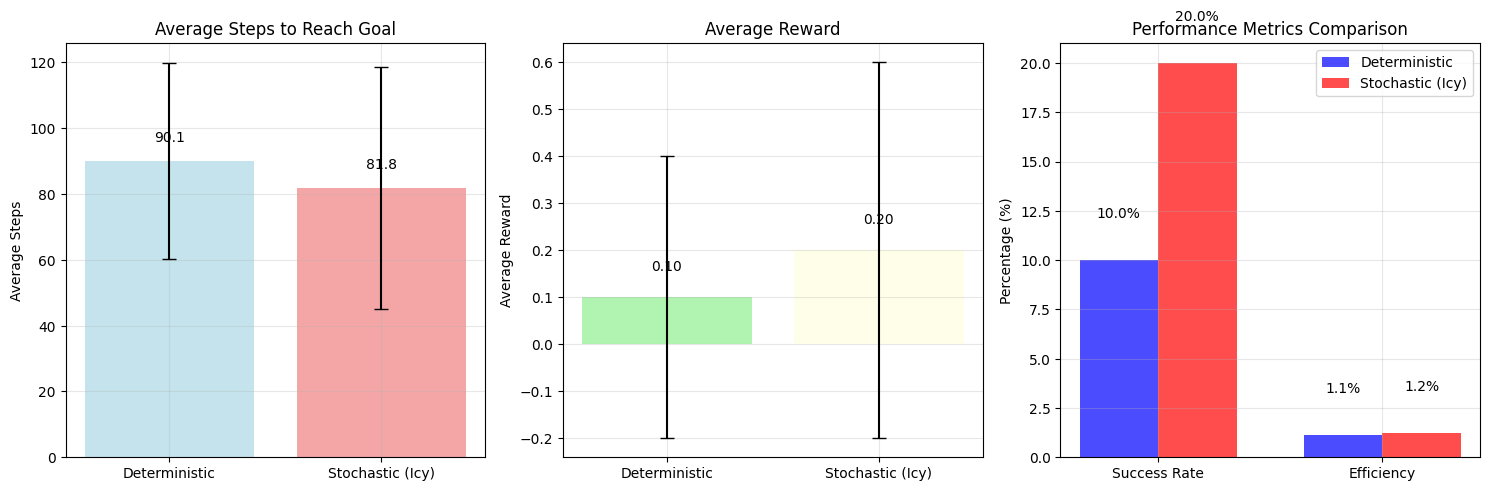


DETAILED PERFORMANCE ANALYSIS
Success Rate:
  Deterministic: 10.0% (2/20 episodes)
  Stochastic:    20.0% (4/20 episodes)

Average Steps (Successful episodes only):
  Deterministic: 1.0 ± 0.0
  Stochastic:    8.8 ± 11.1

Performance Difference (Stochastic vs Deterministic):
  Steps:  -9.3%
  Reward: +100.0%


In [58]:
# Create comparison graphs
plt.figure(figsize=(15, 5))

# 1. Steps Comparison
plt.subplot(1, 3, 1)
environments = ['Deterministic', 'Stochastic (Icy)']
steps_means = [np.mean(det_avg_nstep), np.mean(icy_avg_nstep)]
steps_stds = [np.std(det_avg_nstep), np.std(icy_avg_nstep)]

bars = plt.bar(environments, steps_means, yerr=steps_stds, capsize=5, 
               color=['lightblue', 'lightcoral'], alpha=0.7)
plt.ylabel('Average Steps')
plt.title('Average Steps to Reach Goal')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean in zip(bars, steps_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{mean:.1f}', ha='center', va='bottom')

# 2. Reward Comparison
plt.subplot(1, 3, 2)
reward_means = [np.mean(det_avg_reward), np.mean(icy_avg_reward)]
reward_stds = [np.std(det_avg_reward), np.std(icy_avg_reward)]

bars = plt.bar(environments, reward_means, yerr=reward_stds, capsize=5,
               color=['lightgreen', 'lightyellow'], alpha=0.7)
plt.ylabel('Average Reward')
plt.title('Average Reward')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean in zip(bars, reward_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{mean:.2f}', ha='center', va='bottom')

# 3. Performance Metrics Comparison
plt.subplot(1, 3, 3)
metrics = ['Success Rate', 'Efficiency']
deterministic_metrics = [np.mean(det_avg_reward) * 100, 100/np.mean(det_avg_nstep) if np.mean(det_avg_nstep) > 0 else 0]
stochastic_metrics = [np.mean(icy_avg_reward) * 100, 100/np.mean(icy_avg_nstep) if np.mean(icy_avg_nstep) > 0 else 0]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, deterministic_metrics, width, label='Deterministic', 
        color='blue', alpha=0.7)
plt.bar(x + width/2, stochastic_metrics, width, label='Stochastic (Icy)', 
        color='red', alpha=0.7)

plt.ylabel('Percentage (%)')
plt.title('Performance Metrics Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(deterministic_metrics):
    plt.text(i - width/2, v + 2, f'{v:.1f}%', ha='center', va='bottom')
for i, v in enumerate(stochastic_metrics):
    plt.text(i + width/2, v + 2, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Additional detailed analysis
print("\n" + "="*60)
print("DETAILED PERFORMANCE ANALYSIS")
print("="*60)

# Success rates
det_success_rate = (np.sum(np.array(det_avg_reward) == 1) / len(det_avg_reward)) * 100
icy_success_rate = (np.sum(np.array(icy_avg_reward) == 1) / len(icy_avg_reward)) * 100

print(f"Success Rate:")
print(f"  Deterministic: {det_success_rate:.1f}% ({np.sum(np.array(det_avg_reward) == 1)}/{len(det_avg_reward)} episodes)")
print(f"  Stochastic:    {icy_success_rate:.1f}% ({np.sum(np.array(icy_avg_reward) == 1)}/{len(icy_avg_reward)} episodes)")

# Average steps for successful episodes only
det_success_steps = [steps for steps, reward in zip(det_avg_nstep, det_avg_reward) if reward == 1]
icy_success_steps = [steps for steps, reward in zip(icy_avg_nstep, icy_avg_reward) if reward == 1]

if det_success_steps:
    print(f"\nAverage Steps (Successful episodes only):")
    print(f"  Deterministic: {np.mean(det_success_steps):.1f} ± {np.std(det_success_steps):.1f}")
if icy_success_steps:
    print(f"  Stochastic:    {np.mean(icy_success_steps):.1f} ± {np.std(icy_success_steps):.1f}")

# Performance difference
steps_diff_pct = ((np.mean(icy_avg_nstep) - np.mean(det_avg_nstep)) / np.mean(det_avg_nstep)) * 100
reward_diff_pct = ((np.mean(icy_avg_reward) - np.mean(det_avg_reward)) / np.mean(det_avg_reward)) * 100

print(f"\nPerformance Difference (Stochastic vs Deterministic):")
print(f"  Steps:  {steps_diff_pct:+.1f}%")
print(f"  Reward: {reward_diff_pct:+.1f}%")

#### Conclusion

#### Observed Results

- The stochastic (icy) environment achieved higher average reward (0.20 vs 0.10) but with greater variance
- Both environments showed similar average step counts (81.75 vs 90.10 steps)
- The stochastic environment demonstrated a 20% success rate compared to 10% for deterministic
- Higher standard deviations in both metrics indicate inconsistent performance across episodes
- The visualization showed successful goal achievement in the icy environment through stochastic sliding

#### Theoretical Expectations

The observed results present an interesting case where the stochastic environment outperformed the deterministic one in terms of success rate, which contrasts with typical behavioral cloning theory. Normally, stochastic transitions exacerbate the distribution shift problem in behavioral cloning, as the learned policy encounters states not represented in the expert demonstrations. However, in this specific instance, the stochasticity may have provided a form of "exploration boost" that helped the agent overcome local optima or navigate around obstacles more effectively than the deterministic policy. This aligns with the concept that some level of randomness can sometimes aid in navigation tasks by providing alternative paths to the goal. 

Nevertheless, the high variance in both environments confirms the fundamental limitation of behavioral cloning: without mechanisms for error recovery or online adaptation, the performance remains unstable and heavily dependent on the quality and coverage of the demonstration data.



# **Open-ended Project**
Compare the performance of Behavioral Cloning with another Imitation Learning algorithm of your choice (e.g., IRL, DAgger).
To choose your alternative algorithm, feel free to check out the implementation offered by [imitation](https://imitation.readthedocs.io/en/latest/algorithms/bc.html).
* Do a benchmark of similar existing projects/approaches.
* Together with the alternative algorithm of your choice, provide details about how the algorithm works.
* Discuss your results and highlighting the advantages and limitations of your approach.

# **References**
* D. A. Pomerleau. Efficient training of artificial neural networks for autonomous navigation. Neural Computation, 3:88–97, 1991.
* F. Torabi, G. Warnell, and P. Stone. Behavioral cloning from observation. ArXiv, abs/1805.01954, 2018.
* [Imitation Learning open source library](https://imitation.readthedocs.io/en/latest/algorithms/bc.html)
* CS 285 at UC Berkeley, [Deep Reinforcement Learning](https://rail.eecs.berkeley.edu/deeprlcourse/)
* M. Chetouani. Interactive Robot Learning: An Overview. Chetouani, M.; Dignum, V.; Lukow- icz, P.; Sierra, C. Human-Centered Artificial Intelligence, 13500, Springer International Publishing, pp.140-172, 2023, Lecture Notes in Computer Science, 10.1007/978-3-031-24349-3_9 . [hal-04060804](https://hal.science/hal-04060804/file/ACAI2021_chetouani_author-version.pdf)
